In [1]:
import os
import sys

In [2]:
sys.path.append('../lib')

In [3]:
import cov_independence_test
import hsic_independence_test
import gen_processes

In [4]:
from importlib import reload

In [5]:
reload(cov_independence_test);
reload(hsic_independence_test);
reload(gen_processes);

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel

In [7]:
import scipy.stats as stats

In [8]:
from tqdm import tqdm

In [9]:
from itertools import product

In [10]:
import matplotlib.pyplot as plt

In [81]:
import pickle
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [140]:
LOAD = [
    #'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-16_21.51.24.859309.pickle',
    #'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-19_10.48.21.683491.pickle',
    #'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-19_11.08.53.564837.pickle',
    #'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-19_14.59.01.649995.pickle',
    #'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-19_16.43.50.764135.pickle',
    'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-19_18.27.14.165223.pickle', #latest
    #'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-20_03.50.16.202384.pickle',
    'corr_vs_hsic_comparison_BIG_RESULTS_2022-02-20_22.29.01.352728.pickle'
]

In [141]:
results = []

for path in LOAD:
    with open(path, 'rb') as f:
        results.append(pickle.load(f))

* Results 0:
    * Good showing how decreasing the length of a single signature kernel sample improves performance, visible already even for not-blockwise-bootstrap early runs (16.02)

* Task: plot how the distributions change: 15, 6, 3

In [142]:
for i, result in enumerate(results):
    print()
    print('NEW RES', i)
    print()
    for j, subres in enumerate(result):
        print()
        print('NEW SUBRES', j)
        print()
        pp.pprint(subres)


NEW RES 0


NEW SUBRES 0

{   'COVS': [0, 0.05, 0.1, 0.2, 0.3, 0.4],
    'M_RUNS': 100,
    'NULL': array([-0.00058852, -0.00048779, -0.00048295, ...,  0.00189546,
        0.00221912,  0.00234377]),
    'N_TIMESTEPS': 1800,
    'PROC_DIV': 8,
    'RBF_SIGMA': 2,
    'SIG_KERNEL_SAMPLES_NO': 120,
    'TEST DISTS': {   0: array([-1.34674221e-04, -4.22551656e-05,  7.48832516e-05, -4.88011919e-05,
        6.95272808e-04, -1.24446823e-04,  4.92448788e-04, -3.66637519e-05,
        3.29580676e-05, -1.12671554e-04,  8.19396085e-05, -4.98788187e-05,
       -5.05875685e-05, -5.06255626e-06,  1.23287301e-04, -5.04974590e-05,
        6.92190804e-04, -9.33710824e-05, -5.21573477e-05,  2.23227571e-04,
       -1.42934266e-04, -7.10425443e-05, -2.40599869e-05,  5.54231587e-04,
        3.05828684e-04,  2.12581435e-04,  4.97209334e-04,  7.64889102e-04,
        8.15657361e-06, -1.03102235e-04, -6.56360872e-05, -1.22195896e-04,
        2.12571809e-05,  5.58485893e-05,  4.34596751e-05, -8.74095347e-06,
  

{   'COV RESULTS': {   0: [   (tensor(-0.0791), 0.6976861551406668),
                              (tensor(0.0668), 0.32077175321573415),
                              (tensor(0.1725), 0.11536848698730728),
                              (tensor(0.0532), 0.34135204919841977),
                              (tensor(0.0821), 0.2638897875897199),
                              (tensor(0.1743), 0.13025701139720525),
                              (tensor(0.1094), 0.23342667025114716),
                              (tensor(-0.1160), 0.772447618503433),
                              (tensor(-0.1893), 0.9063148986627754),
                              (tensor(-0.0277), 0.5776868278182548),
                              (tensor(0.1561), 0.08998491510524265),
                              (tensor(0.1397), 0.13709669942812752),
                              (tensor(0.0110), 0.47112964837996973),
                              (tensor(0.0117), 0.46407124013501),
                              (tensor(0

                                (tensor(0.9238), 2.0194201866274852e-10),
                                (tensor(0.7389), 2.4559787537015154e-10),
                                (tensor(0.8265), 9.551855972844692e-10),
                                (tensor(0.9828), 1.7203360958006897e-10),
                                (tensor(0.7679), 1.5015588550326697e-08),
                                (tensor(0.6625), 1.1780316744314234e-07),
                                (tensor(0.9043), 9.205658457744903e-11),
                                (tensor(0.8631), 3.0694335961811703e-12),
                                (tensor(0.9361), 2.509070728962115e-11),
                                (tensor(0.9873), 1.0714873432959848e-11),
                                (tensor(0.5404), 1.4575344274958546e-05),
                                (tensor(1.0597), 3.176348073452573e-13),
                                (tensor(0.7738), 1.3824839495413244e-08),
                                (tensor(0.

                                (tensor(0.9227), 3.657094816866824e-06),
                                (tensor(0.9821), 2.74101163988405e-09),
                                (tensor(0.7462), 0.00023464277459750438),
                                (tensor(1.0302), 5.929303463769742e-07),
                                (tensor(0.9638), 1.886221253266651e-05),
                                (tensor(0.6833), 2.0986500284370102e-05),
                                (tensor(1.1623), 3.232975231970414e-08),
                                (tensor(0.9195), 2.0979900567930088e-06),
                                (tensor(0.8868), 8.118365791509596e-06),
                                (tensor(1.0829), 7.54767779387322e-08),
                                (tensor(1.0005), 4.433462769126706e-07),
                                (tensor(0.9558), 1.2408883515835356e-05),
                                (tensor(1.1025), 3.4228316847517704e-09),
                                (tensor(0.9191),

                                (tensor(0.9667), 4.165445766091125e-10),
                                (tensor(0.8607), 7.748135466556505e-11),
                                (tensor(0.8121), 2.2212720551806342e-10),
                                (tensor(0.8608), 4.341336179436439e-10),
                                (tensor(1.0490), 1.7231771565207055e-12),
                                (tensor(0.6872), 1.0541425329302356e-06),
                                (tensor(0.9164), 2.987592395697902e-10),
                                (tensor(0.9784), 1.1546319456101628e-13),
                                (tensor(0.7714), 1.2720273490085532e-07)],
                       0.4: [   (tensor(1.0639), 2.595701431573616e-13),
                                (tensor(0.8869), 2.6255664309360327e-12),
                                (tensor(1.0814), 1.1102230246251565e-16),
                                (tensor(1.0705), 5.901945598907332e-13),
                                (tensor(0.8

In [143]:
results_15_samples = results[0][1] #0.3 only is interesting
results_6_samples = results[1][0] #0 - 0.4
results_2_samples = results[0][3] #0.3 only

In [152]:
pp.pprint(results_6_samples)

{   'COMMENT': 'Using the V_statistic now, faster and also seems reliable',
    'COV RESULTS': {   0: [   (tensor(-0.0222), 0.5637762016029908),
                              (tensor(-0.1464), 0.8555494894912712),
                              (tensor(0.0224), 0.42310667416729053),
                              (tensor(-0.0653), 0.6785299932816475),
                              (tensor(-0.2495), 0.9441534752214008),
                              (tensor(-0.2307), 0.9580212389119143),
                              (tensor(-0.0068), 0.5185675384514798),
                              (tensor(-0.1428), 0.8732500765961182),
                              (tensor(-0.1064), 0.7436313912901735),
                              (tensor(-0.0056), 0.5173030759383901),
                              (tensor(0.0981), 0.2287774081873668),
                              (tensor(0.0454), 0.36386043976343263),
                              (tensor(-0.0448), 0.6065079247111943),
                            

In [157]:
def get_hsic_test_power(results, null):
    q = np.quantile(null, 0.95)
    
    return (results > q).sum()/len(results)

In [ ]:
def get_corr_test_power(results):
    a = 0
    
    for res in results:
        a += (res[1] > 0.975) | (res[1] < 0.025)
    
    return a/len(results)

In [168]:
get_corr_test_power(results_6_samples['COV RESULTS'][0.1])
get_hsic_test_power(results_6_samples['TEST DISTS'][0.1], results_6_samples['NULL'])

0.48

In [ ]:
get_hsic_test_power()

In [ ]:
for i, r in enumerate([results_15_samples, results_6_samples, results_2_samples]):


In [172]:
corr_powers = []
hsic_powers = []
corr = results_6_samples['COVS'][1:]
print(corr)
for cov in corr:
    corr_powers.append(get_corr_test_power(results_6_samples['COV RESULTS'][cov]))
    hsic_powers.append(get_hsic_test_power(results_6_samples['TEST DISTS'][cov], results_6_samples['NULL']))

[0.05, 0.1, 0.2, 0.3, 0.4]


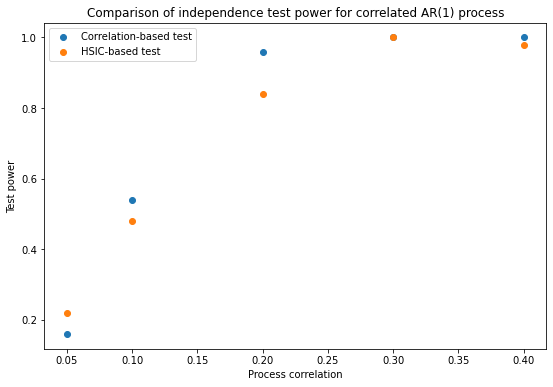

In [179]:
plt.figure(figsize = (9, 6))
plt.title('Comparison of independence test power for correlated AR(1) process')
plt.scatter(corr, corr_powers, label = 'Correlation-based test')
plt.scatter(corr, hsic_powers, label = 'HSIC-based test')
plt.ylabel('Test power')
plt.xlabel('Process correlation')
plt.legend()
plt.savefig('./pics/corr_vs_hisc_test_on_correlated_ar_1.png')


In [173]:
#plt.savefig('./pics/hsic_null_alternative_corr_03_length_{}.png'.format(lengths[i]))

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <BarContainer object of 10 artists>)

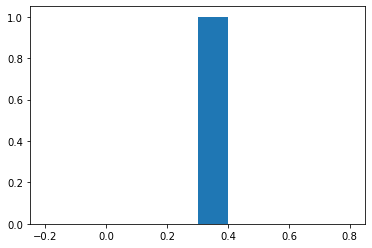

In [94]:
plt.hist(results[0][0]['TEST DISTS'])

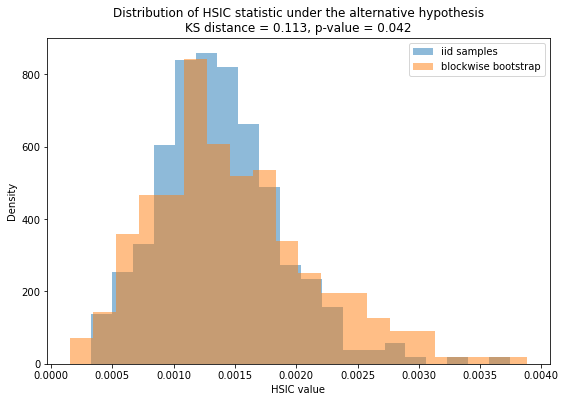

In [80]:
#null_sampling_approx = null_approx.numpy()

res = stats.ks_2samp(results_2[1]['SHORT_SCORES'], results_3[0]['SHORT_SCORES'])
plt.figure(figsize = (9, 6))
plt.title("Distribution of HSIC statistic under the alternative hypothesis\nKS distance = {:.3f}, p-value = {:.3f}".format(res.statistic, res.pvalue))
plt.hist(results_2[1]['SHORT_SCORES'], bins = 20, alpha = 0.5, label = 'iid samples', density = True);
plt.hist(results_3[0]['SHORT_SCORES'], bins = 20, alpha = 0.5, label = 'blockwise bootstrap', density = True);
plt.xlabel('HSIC value')
plt.ylabel('Density')
plt.legend()
plt.savefig('./pics/hsic_under_iid_vs_bootstrap.png')


In [ ]:
main_result = {
    'length_15_u_statistic': results_15_samples
    'length_6': results_6_samples,
    'length_2' : results_2_samples,
}

In [145]:
with open('./pickles/test_eval_linear_dependence_different_sample_lengths.pickle', 'wb') as f:
    pickle.dump(main_result, f)

In [53]:
null = stats.gamma(*stats.gamma.fit(null_sampling_approx))

NameError: name 'null_sampling_approx' is not defined

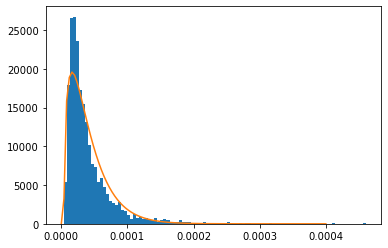

In [48]:
x = np.linspace(0, 4e-4, 100)
bins = plt.hist(null_sampling_approx, bins = 100, density = True);
plt.plot(x, null.pdf(x))

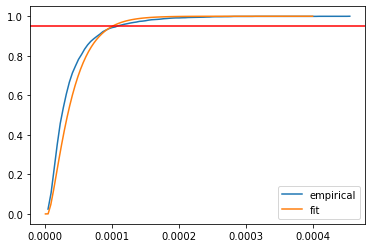

In [65]:
x = np.linspace(0, 4e-4, 100)
plt.plot(bins[1][:100], (np.diff(bins[1])*bins[0]).cumsum(), label = 'empirical')
plt.plot(x, null.cdf(x), label = 'fit')
plt.axhline(0.95, color = 'red')
plt.legend()

In [30]:
with open('./null_approx_numerical_rbf_s2_div8.pickle', 'rb') as f:
    null_ustat_approx = pickle.load(f)
with open('./hisc_dist_corr_03_60_samples.pickle', 'rb') as f:
    hsic_corr_03_approx = pickle.load(f)

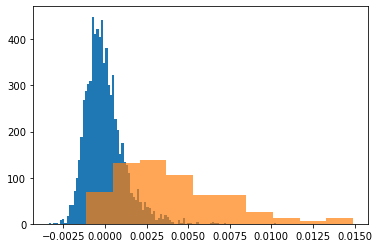

In [31]:
plt.hist(null_ustat_approx.numpy(), bins = 100, density = True);
plt.hist(hsic_corr_03_approx, density = True, alpha = 0.7);